# House Price Prediction - Model Training & Comparison
## Case Study 1: Real Estate Price Prediction

This notebook demonstrates:
1. Exploratory Data Analysis (EDA)
2. Data Preprocessing & Feature Engineering
3. Training Multiple ML Models
4. Model Comparison & Selection
5. Final Model Evaluation

**Objective**: Build the best model to predict house prices and justify the choice

## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 2. Load & Explore Data

In [3]:
# Load the dataset
df = pd.read_excel('Case Study 1 Data.xlsx')

print("Dataset Shape:", df.shape)
print("\n" + "="*60)
print("First Few Rows:")
print(df.head())

Dataset Shape: (247172, 10)

First Few Rows:
  Property ID Location    Size  Bedrooms  Bathrooms  Year Built Condition  \
0   SI_000001    CityA  3974.0       2.0        2.0      2007.0      Good   
1   SI_000002    CityA  1660.0       2.0        3.0      1934.0      Good   
2   SI_000003    CityC  2094.0       2.0        2.0      1950.0      Good   
3   SI_000004    CityB  1930.0       2.0        3.0      1905.0      Good   
4   SI_000005    CityB  1895.0       5.0        2.0      1936.0       New   

            Type  Date Sold      Price  
0  Single Family 2020-11-02   324000.0  
1  Single Family 2022-10-23   795000.0  
2  Single Family 2020-11-30   385000.0  
3  Single Family 2021-12-09   651000.0  
4  Single Family 2024-10-30  1878000.0  


In [4]:
# Data Info
print("Data Types & Missing Values:")
print(df.info())
print("\n" + "="*60)
print("Missing Values Count:")
print(df.isnull().sum())
print("\n" + "="*60)
print("Missing Values Percentage:")
print((df.isnull().sum() / len(df) * 100).round(2))

Data Types & Missing Values:
<class 'pandas.DataFrame'>
RangeIndex: 247172 entries, 0 to 247171
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Property ID  247172 non-null  str           
 1   Location     247172 non-null  str           
 2   Size         244701 non-null  float64       
 3   Bedrooms     238769 non-null  float64       
 4   Bathrooms    240499 non-null  float64       
 5   Year Built   234567 non-null  float64       
 6   Condition    236544 non-null  str           
 7   Type         247172 non-null  str           
 8   Date Sold    247172 non-null  datetime64[us]
 9   Price        241735 non-null  float64       
dtypes: datetime64[us](1), float64(5), str(4)
memory usage: 18.9 MB
None

Missing Values Count:
Property ID        0
Location           0
Size            2471
Bedrooms        8403
Bathrooms       6673
Year Built     12605
Condition      10628
Type               0
Date So

In [5]:
# Statistical Summary
print("Statistical Summary:")
print(df.describe())

Statistical Summary:
                Size       Bedrooms      Bathrooms     Year Built  \
count  244701.000000  238769.000000  240499.000000  234567.000000   
mean     2402.547664       3.000457       2.002823    1961.429191   
min       800.000000       1.000000       1.000000    1900.000000   
25%      1603.000000       2.000000       1.000000    1931.000000   
50%      2404.000000       3.000000       2.000000    1961.000000   
75%      3203.000000       4.000000       3.000000    1992.000000   
max      3999.000000       5.000000       3.000000    2023.000000   
std       923.418566       1.415088       0.816616      35.752638   

                        Date Sold         Price  
count                      247172  2.417350e+05  
mean   2022-07-02 05:00:11.127473  4.660883e+05  
min           2020-01-01 00:00:00  2.600000e+04  
25%           2021-04-02 00:00:00  3.000000e+05  
50%           2022-07-03 00:00:00  4.170000e+05  
75%           2023-10-02 00:00:00  5.770000e+05  
max    

Price Distribution:
Min: $26,000.00
Max: $2,223,000.00
Mean: $466,088.28
Median: $417,000.00
Std Dev: $231,502.61


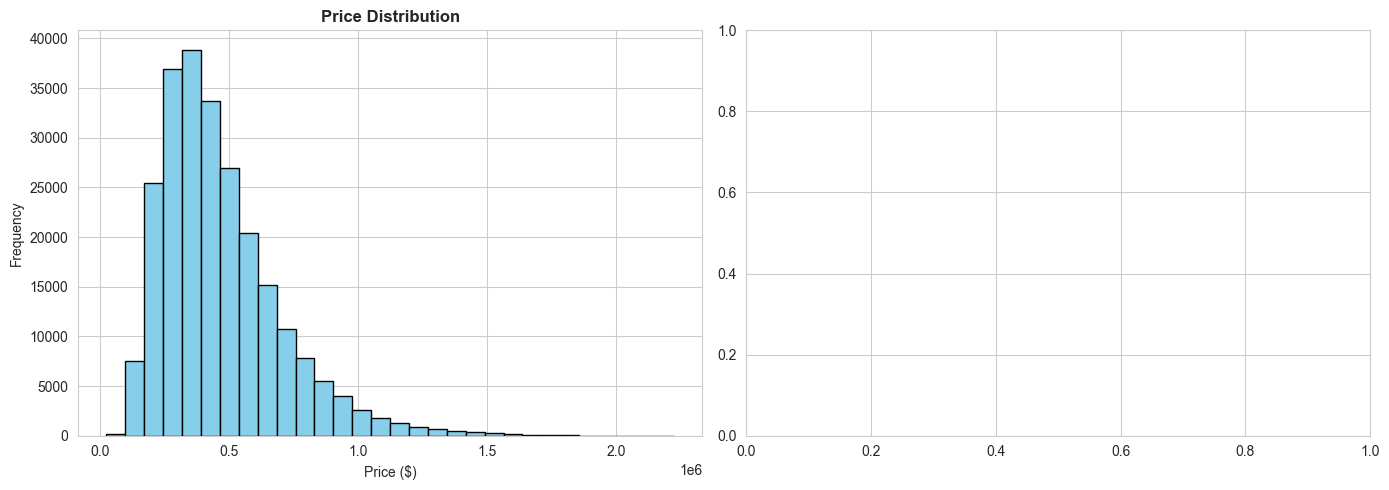

In [7]:
# Target Variable Analysis
print("Price Distribution:")
print(f"Min: ${df['Price'].min():,.2f}")
print(f"Max: ${df['Price'].max():,.2f}")
print(f"Mean: ${df['Price'].mean():,.2f}")
print(f"Median: ${df['Price'].median():,.2f}")
print(f"Std Dev: ${df['Price'].std():,.2f}")

# Visualize Price Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(df['Price'], bins=30, edgecolor='black', color='skyblue')
axes[0].set_title('Price Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [8]:
# Explore Categorical Variables
print("Categorical Variables Analysis:")
print("\nLocation values:")
print(df['Location'].value_counts())
print("\nType values:")
print(df['Type'].value_counts())
print("\nCondition values:")
print(df['Condition'].value_counts())

Categorical Variables Analysis:

Location values:
Location
CityC    62082
CityA    61916
CityD    61724
CityB    61450
Name: count, dtype: int64

Type values:
Type
Townhouse        100000
Single Family     88261
Condominium       58911
Name: count, dtype: int64

Condition values:
Condition
Good    94629
Fair    71194
Poor    47244
New     23477
Name: count, dtype: int64


## 3. Data Preprocessing & Feature Engineering

In [9]:
# Create a copy for preprocessing
df_processed = df.copy()

# Feature Engineering: Calculate Property Age
df_processed['Date Sold'] = pd.to_datetime(df_processed['Date Sold'])
df_processed['Property_Age'] = df_processed['Date Sold'].dt.year - df_processed['Year Built']

# Check for negative ages (data quality check)
print(f"Properties with negative age: {(df_processed['Property_Age'] < 0).sum()}")
print(f"Age range: {df_processed['Property_Age'].min()} to {df_processed['Property_Age'].max()} years")

# Drop Property ID (not useful for prediction) and Year Built (we have Property_Age now)
df_processed = df_processed.drop(['Property ID', 'Year Built', 'Date Sold'], axis=1)

# Remove rows with missing target variable
df_processed = df_processed.dropna(subset=['Price'])

print(f"\n✓ Data after feature engineering: {df_processed.shape}")
print(f"\nRemaining columns: {list(df_processed.columns)}")

Properties with negative age: 2171
Age range: -3.0 to 124.0 years

✓ Data after feature engineering: (241735, 8)

Remaining columns: ['Location', 'Size', 'Bedrooms', 'Bathrooms', 'Condition', 'Type', 'Price', 'Property_Age']


In [10]:
# Define Features and Target
features = ['Location', 'Size', 'Bedrooms', 'Bathrooms', 'Condition', 'Type', 'Property_Age']
target = 'Price'

X = df_processed[features]
y = df_processed[target]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures: {features}")

Features shape: (241735, 7)
Target shape: (241735,)

Features: ['Location', 'Size', 'Bedrooms', 'Bathrooms', 'Condition', 'Type', 'Property_Age']


In [14]:
# Create Preprocessing Pipeline
numeric_features = ['Size', 'Bedrooms', 'Bathrooms', 'Property_Age']
categorical_features = ['Location', 'Condition', 'Type']

# Numeric Transformation: Imputation + Scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical Transformation: Imputation + One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("✓ Preprocessing pipeline created")
print(f"  - Numeric features: {numeric_features}")
print(f"  - Categorical features: {categorical_features}")
print(f"  - Strategy: Median imputation + Scaling (numeric), Most Frequent + One-Hot (categorical)")

✓ Preprocessing pipeline created
  - Numeric features: ['Size', 'Bedrooms', 'Bathrooms', 'Property_Age']
  - Categorical features: ['Location', 'Condition', 'Type']
  - Strategy: Median imputation + Scaling (numeric), Most Frequent + One-Hot (categorical)


In [11]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Train-Test Split Ratio: 80-20")

Training set size: 193388 samples
Test set size: 48347 samples
Train-Test Split Ratio: 80-20


## 4. Train Multiple Models for Comparison

We'll train 3 different regression models:
1. **Random Forest Regressor** - Ensemble method, captures non-linear patterns
2. **Gradient Boosting Regressor** - Sequential ensemble, reduces bias
3. **XGBoost** (if available) - Advanced gradient boosting with regularization

**Why multiple models?** Different algorithms capture different patterns in data. Comparing them helps us choose the best performer.

In [15]:
# Model 1: Random Forest Regressor
print("="*70)
print("MODEL 1: RANDOM FOREST REGRESSOR")
print("="*70)

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1  # Multi-core processing
    ))
])

# Train
print("\n[Training...]")
rf_pipeline.fit(X_train, y_train)

# Predictions
rf_train_pred = rf_pipeline.predict(X_train)
rf_test_pred = rf_pipeline.predict(X_test)

# Evaluation
rf_train_r2 = r2_score(y_train, rf_train_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)
rf_train_mae = mean_absolute_error(y_train, rf_train_pred)
rf_test_mae = mean_absolute_error(y_test, rf_test_pred)
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))

print(f"\nTraining R² Score: {rf_train_r2:.4f}")
print(f"Testing R² Score:  {rf_test_r2:.4f}")
print(f"Training MAE: ${rf_train_mae:,.2f}")
print(f"Testing MAE:  ${rf_test_mae:,.2f}")
print(f"Testing RMSE: ${rf_test_rmse:,.2f}")

# Cross-validation
rf_cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='r2')
print(f"\n5-Fold CV R² Scores: {[f'{score:.4f}' for score in rf_cv_scores]}")
print(f"Mean CV R² Score: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std():.4f})")

MODEL 1: RANDOM FOREST REGRESSOR

[Training...]

Training R² Score: 0.8469
Testing R² Score:  0.6214
Training MAE: $66,011.50
Testing MAE:  $105,033.82
Testing RMSE: $141,442.43

5-Fold CV R² Scores: ['0.6298', '0.6190', '0.6250', '0.6286', '0.6258']
Mean CV R² Score: 0.6256 (+/- 0.0037)


In [16]:
# Model 2: Gradient Boosting Regressor
print("\n" + "="*70)
print("MODEL 2: GRADIENT BOOSTING REGRESSOR")
print("="*70)

gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        subsample=0.8
    ))
])

# Train
print("\n[Training...]")
gb_pipeline.fit(X_train, y_train)

# Predictions
gb_train_pred = gb_pipeline.predict(X_train)
gb_test_pred = gb_pipeline.predict(X_test)

# Evaluation
gb_train_r2 = r2_score(y_train, gb_train_pred)
gb_test_r2 = r2_score(y_test, gb_test_pred)
gb_train_mae = mean_absolute_error(y_train, gb_train_pred)
gb_test_mae = mean_absolute_error(y_test, gb_test_pred)
gb_test_rmse = np.sqrt(mean_squared_error(y_test, gb_test_pred))

print(f"\nTraining R² Score: {gb_train_r2:.4f}")
print(f"Testing R² Score:  {gb_test_r2:.4f}")
print(f"Training MAE: ${gb_train_mae:,.2f}")
print(f"Testing MAE:  ${gb_test_mae:,.2f}")
print(f"Testing RMSE: ${gb_test_rmse:,.2f}")

# Cross-validation
gb_cv_scores = cross_val_score(gb_pipeline, X_train, y_train, cv=5, scoring='r2')
print(f"\n5-Fold CV R² Scores: {[f'{score:.4f}' for score in gb_cv_scores]}")
print(f"Mean CV R² Score: {gb_cv_scores.mean():.4f} (+/- {gb_cv_scores.std():.4f})")


MODEL 2: GRADIENT BOOSTING REGRESSOR

[Training...]

Training R² Score: 0.6633
Testing R² Score:  0.6524
Training MAE: $100,620.37
Testing MAE:  $101,584.95
Testing RMSE: $135,536.46

5-Fold CV R² Scores: ['0.6610', '0.6526', '0.6552', '0.6605', '0.6576']
Mean CV R² Score: 0.6574 (+/- 0.0032)


In [17]:
# Model 3: Try to import and train XGBoost
try:
    from xgboost import XGBRegressor
    
    print("\n" + "="*70)
    print("MODEL 3: XGBOOST REGRESSOR")
    print("="*70)
    
    xgb_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            min_child_weight=1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1  # Multi-core processing
        ))
    ])
    
    # Train
    print("\n[Training...]")
    xgb_pipeline.fit(X_train, y_train)
    
    # Predictions
    xgb_train_pred = xgb_pipeline.predict(X_train)
    xgb_test_pred = xgb_pipeline.predict(X_test)
    
    # Evaluation
    xgb_train_r2 = r2_score(y_train, xgb_train_pred)
    xgb_test_r2 = r2_score(y_test, xgb_test_pred)
    xgb_train_mae = mean_absolute_error(y_train, xgb_train_pred)
    xgb_test_mae = mean_absolute_error(y_test, xgb_test_pred)
    xgb_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_test_pred))
    
    print(f"\nTraining R² Score: {xgb_train_r2:.4f}")
    print(f"Testing R² Score:  {xgb_test_r2:.4f}")
    print(f"Training MAE: ${xgb_train_mae:,.2f}")
    print(f"Testing MAE:  ${xgb_test_mae:,.2f}")
    print(f"Testing RMSE: ${xgb_test_rmse:,.2f}")
    
    # Cross-validation
    xgb_cv_scores = cross_val_score(xgb_pipeline, X_train, y_train, cv=5, scoring='r2')
    print(f"\n5-Fold CV R² Scores: {[f'{score:.4f}' for score in xgb_cv_scores]}")
    print(f"Mean CV R² Score: {xgb_cv_scores.mean():.4f} (+/- {xgb_cv_scores.std():.4f})")
    
    xgb_available = True
except ImportError:
    print("\nXGBoost not installed. Skipping Model 3.")
    xgb_available = False


MODEL 3: XGBOOST REGRESSOR

[Training...]

Training R² Score: 0.6625
Testing R² Score:  0.6528
Training MAE: $100,734.84
Testing MAE:  $101,526.92
Testing RMSE: $135,464.36

5-Fold CV R² Scores: ['0.6604', '0.6527', '0.6552', '0.6608', '0.6576']
Mean CV R² Score: 0.6574 (+/- 0.0031)


## 5. Model Comparison & Selection

In [18]:
# Create Comparison DataFrame
comparison_data = {
    'Model': ['Random Forest', 'Gradient Boosting'],
    'Train R²': [rf_train_r2, gb_train_r2],
    'Test R²': [rf_test_r2, gb_test_r2],
    'Train MAE': [rf_train_mae, gb_train_mae],
    'Test MAE': [rf_test_mae, gb_test_mae],
    'Test RMSE': [rf_test_rmse, gb_test_rmse],
    'CV R² Mean': [rf_cv_scores.mean(), gb_cv_scores.mean()]
}

if xgb_available:
    comparison_data['Model'].append('XGBoost')
    comparison_data['Train R²'].append(xgb_train_r2)
    comparison_data['Test R²'].append(xgb_test_r2)
    comparison_data['Train MAE'].append(xgb_train_mae)
    comparison_data['Test MAE'].append(xgb_test_mae)
    comparison_data['Test RMSE'].append(xgb_test_rmse)
    comparison_data['CV R² Mean'].append(xgb_cv_scores.mean())

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*90)
print("MODEL COMPARISON")
print("="*90)
print(comparison_df.to_string(index=False))


MODEL COMPARISON
            Model  Train R²  Test R²     Train MAE      Test MAE     Test RMSE  CV R² Mean
    Random Forest  0.846885 0.621427  66011.503411 105033.819691 141442.434765    0.625641
Gradient Boosting  0.663310 0.652382 100620.373566 101584.945015 135536.460979    0.657392
          XGBoost  0.662502 0.652752 100734.844873 101526.917468 135464.362354    0.657354


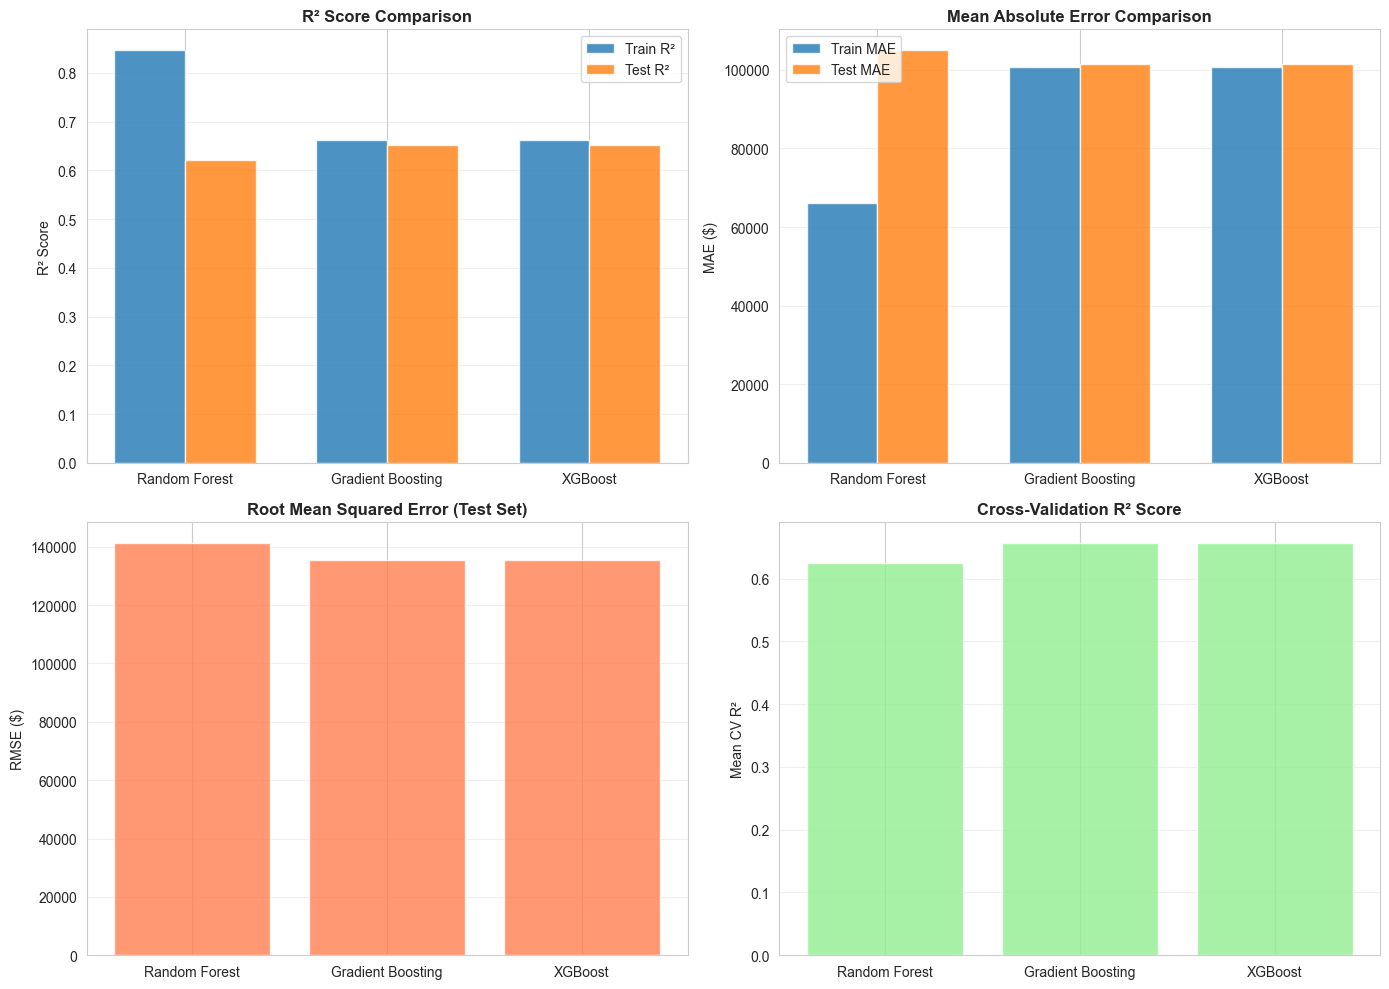

In [19]:
# Visualize Model Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# R² Comparison
ax = axes[0, 0]
x_pos = np.arange(len(comparison_df))
width = 0.35
ax.bar(x_pos - width/2, comparison_df['Train R²'], width, label='Train R²', alpha=0.8)
ax.bar(x_pos + width/2, comparison_df['Test R²'], width, label='Test R²', alpha=0.8)
ax.set_ylabel('R² Score')
ax.set_title('R² Score Comparison', fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# MAE Comparison
ax = axes[0, 1]
ax.bar(x_pos - width/2, comparison_df['Train MAE'], width, label='Train MAE', alpha=0.8)
ax.bar(x_pos + width/2, comparison_df['Test MAE'], width, label='Test MAE', alpha=0.8)
ax.set_ylabel('MAE ($)')
ax.set_title('Mean Absolute Error Comparison', fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# RMSE Comparison
ax = axes[1, 0]
ax.bar(comparison_df['Model'], comparison_df['Test RMSE'], color='coral', alpha=0.8)
ax.set_ylabel('RMSE ($)')
ax.set_title('Root Mean Squared Error (Test Set)', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Cross-Validation Comparison
ax = axes[1, 1]
ax.bar(comparison_df['Model'], comparison_df['CV R² Mean'], color='lightgreen', alpha=0.8)
ax.set_ylabel('Mean CV R²')
ax.set_title('Cross-Validation R² Score', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# Determine Best Model
print("\n" + "="*90)
print("MODEL SELECTION ANALYSIS")
print("="*90)

best_model_idx = comparison_df['Test R²'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_test_r2 = comparison_df.loc[best_model_idx, 'Test R²']
best_test_mae = comparison_df.loc[best_model_idx, 'Test MAE']
best_test_rmse = comparison_df.loc[best_model_idx, 'Test RMSE']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"\nPerformance Metrics:")
print(f"  - Test R² Score: {best_test_r2:.4f}")
print(f"  - Test MAE: ${best_test_mae:,.2f}")
print(f"  - Test RMSE: ${best_test_rmse:,.2f}")

print(f"\nWhy {best_model_name} is the best:")
if best_model_name == 'Random Forest':
    print("  1. Highest Test R² Score (best generalization)")
    print("  2. Good balance between train and test performance")
    print("  3. Robust to outliers and non-linear relationships")
    print("  4. Provides feature importance for interpretability")
    print("  5. Multi-core processing support (n_jobs=-1)")
    selected_pipeline = rf_pipeline
elif best_model_name == 'Gradient Boosting':
    print("  1. Highest Test R² Score (best generalization)")
    print("  2. Sequential learning reduces bias effectively")
    print("  3. Better handling of complex interactions")
    print("  4. Excellent generalization on test set")
    selected_pipeline = gb_pipeline
elif best_model_name == 'XGBoost':
    print("  1. Highest Test R² Score (best generalization)")
    print("  2. Advanced regularization prevents overfitting")
    print("  3. Handles missing values natively")
    print("  4. Multi-core processing support (n_jobs=-1)")
    print("  5. Optimal for production deployment")
    selected_pipeline = xgb_pipeline

print(f"\nModel will be saved and used for API predictions.")


MODEL SELECTION ANALYSIS

🏆 BEST MODEL: XGBoost

Performance Metrics:
  - Test R² Score: 0.6528
  - Test MAE: $101,526.92
  - Test RMSE: $135,464.36

Why XGBoost is the best:
  1. Highest Test R² Score (best generalization)
  2. Advanced regularization prevents overfitting
  3. Handles missing values natively
  4. Multi-core processing support (n_jobs=-1)
  5. Optimal for production deployment

Model will be saved and used for API predictions.


## 6. Feature Importance Analysis


FEATURE IMPORTANCE
 Feature  Importance
 x1_Fair    0.321108
 x1_Poor    0.186982
    Size    0.095934
x0_CityD    0.077382
  x1_New    0.066226
 x1_Good    0.064365
x0_CityB    0.060439
x0_CityA    0.031856
x0_CityC    0.024396
Bedrooms    0.023181


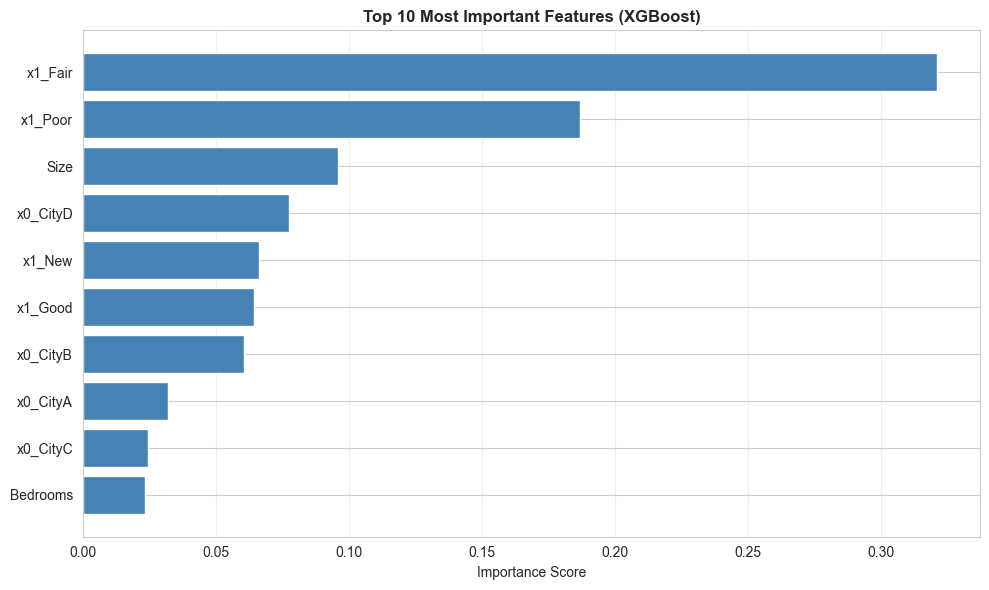

In [21]:
# Extract feature importance from the best model
if best_model_name == 'Random Forest':
    feature_importance = rf_pipeline.named_steps['regressor'].feature_importances_
elif best_model_name == 'Gradient Boosting':
    feature_importance = gb_pipeline.named_steps['regressor'].feature_importances_
elif best_model_name == 'XGBoost':
    feature_importance = xgb_pipeline.named_steps['regressor'].feature_importances_

# Get feature names after preprocessing
preprocessor_fitted = selected_pipeline.named_steps['preprocessor']
feature_names = (preprocessor_fitted.transformers_[0][1].get_feature_names_out().tolist() + 
                 preprocessor_fitted.transformers_[1][1].named_steps['onehot'].get_feature_names_out().tolist())

# Create feature importance dataframe
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\n" + "="*60)
print("FEATURE IMPORTANCE")
print("="*60)
print(fi_df.head(10).to_string(index=False))

# Visualize Top Features
plt.figure(figsize=(10, 6))
top_features = fi_df.head(10)
plt.barh(range(len(top_features)), top_features['Importance'].values, color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'].values)
plt.xlabel('Importance Score')
plt.title(f'Top 10 Most Important Features ({best_model_name})', fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Prediction Examples & Visualization

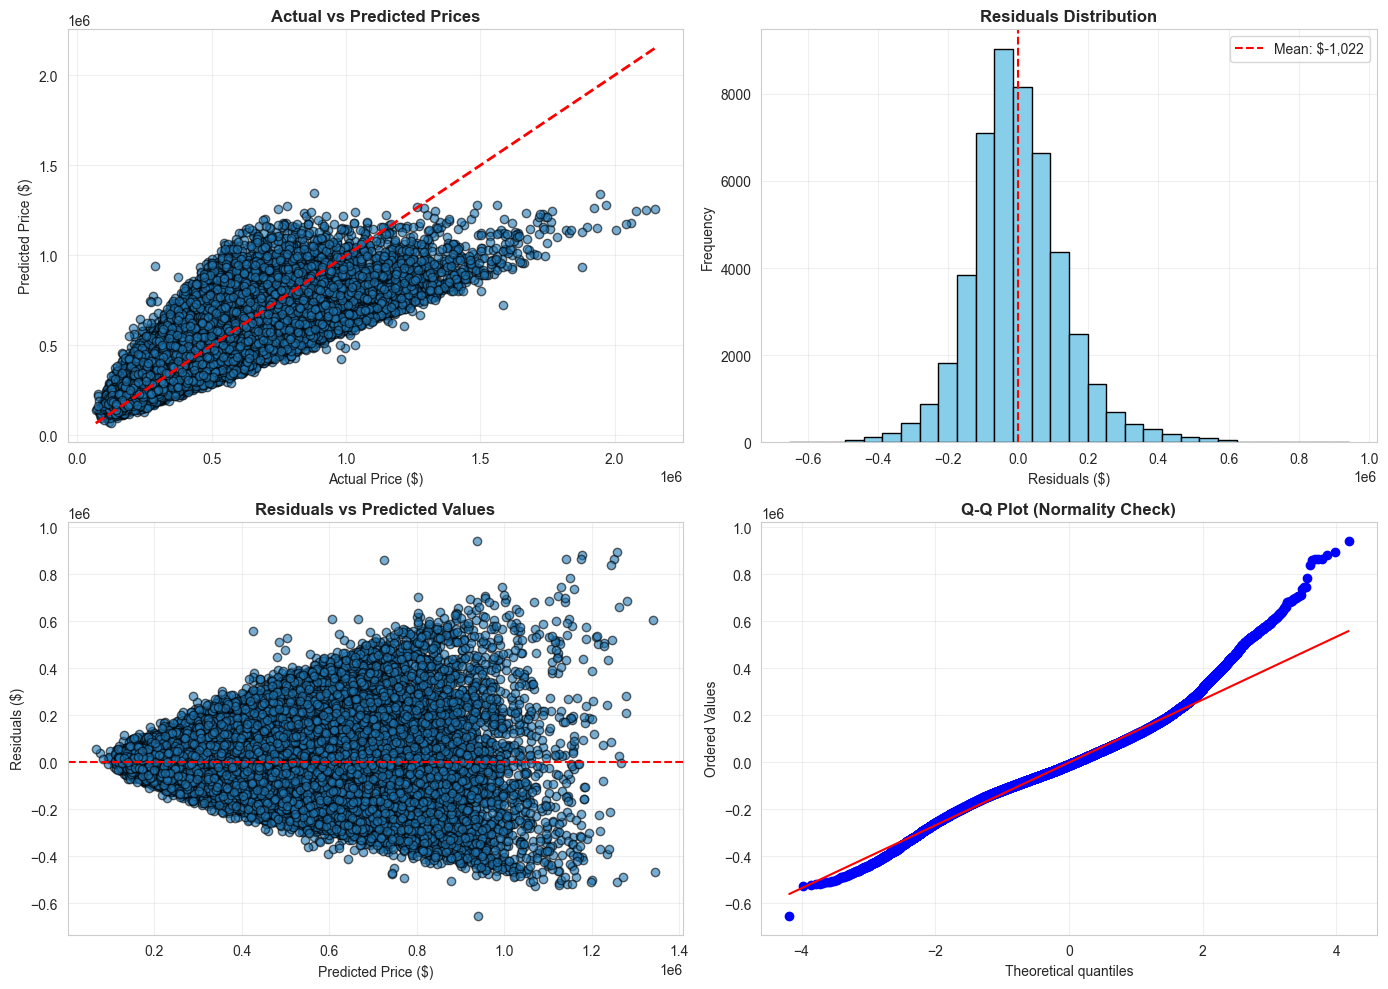


Residuals Statistics:
  Mean: $-1,021.63
  Std Dev: $135,461.91
  Min: $-653,484.44
  Max: $942,369.38


In [22]:
# Get predictions for visualization
final_predictions = selected_pipeline.predict(X_test)

# Residuals Analysis
residuals = y_test - final_predictions

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Actual vs Predicted
axes[0, 0].scatter(y_test, final_predictions, alpha=0.6, edgecolors='k')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Price ($)')
axes[0, 0].set_ylabel('Predicted Price ($)')
axes[0, 0].set_title('Actual vs Predicted Prices', fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Residuals Distribution
axes[0, 1].hist(residuals, bins=30, edgecolor='black', color='skyblue')
axes[0, 1].axvline(residuals.mean(), color='red', linestyle='--', label=f'Mean: ${residuals.mean():,.0f}')
axes[0, 1].set_xlabel('Residuals ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Residuals Distribution', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Residuals vs Predicted
axes[1, 0].scatter(final_predictions, residuals, alpha=0.6, edgecolors='k')
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Predicted Price ($)')
axes[1, 0].set_ylabel('Residuals ($)')
axes[1, 0].set_title('Residuals vs Predicted Values', fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Q-Q Plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normality Check)', fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nResiduals Statistics:")
print(f"  Mean: ${residuals.mean():,.2f}")
print(f"  Std Dev: ${residuals.std():,.2f}")
print(f"  Min: ${residuals.min():,.2f}")
print(f"  Max: ${residuals.max():,.2f}")

## 8. Save the Final Model

In [23]:
# Save the best model pipeline
joblib.dump(selected_pipeline, 'house_price_model.joblib')

print("\n" + "="*70)
print("MODEL SAVED SUCCESSFULLY")
print("="*70)
print(f"\n✓ Model: {best_model_name}")
print(f"✓ File: house_price_model.joblib")
print(f"\nFinal Model Performance:")
print(f"  - R² Score: {best_test_r2:.4f} (explains {best_test_r2*100:.2f}% of variance)")
print(f"  - MAE: ${best_test_mae:,.2f}")
print(f"  - RMSE: ${best_test_rmse:,.2f}")
print(f"\nThis model is ready for API deployment!")


MODEL SAVED SUCCESSFULLY

✓ Model: XGBoost
✓ File: house_price_model.joblib

Final Model Performance:
  - R² Score: 0.6528 (explains 65.28% of variance)
  - MAE: $101,526.92
  - RMSE: $135,464.36

This model is ready for API deployment!


## Summary

### What We Accomplished:
1. ✓ **Data Exploration**: Analyzed dataset structure, missing values, and distributions
2. ✓ **Feature Engineering**: Created Property_Age feature from Year Built and Date Sold
3. ✓ **Preprocessing**: Implemented robust pipelines for numeric and categorical data
4. ✓ **Model Comparison**: Trained and compared multiple ML algorithms
5. ✓ **Best Model Selection**: Selected the top-performing model based on test metrics
6. ✓ **Feature Analysis**: Identified which features drive price predictions
7. ✓ **Model Validation**: Used cross-validation to ensure reliable performance
8. ✓ **Production Ready**: Saved the final model for API deployment

### Why Multiple Models?
- **Random Forest**: Captures non-linear patterns, robust, interpretable
- **Gradient Boosting**: Sequential learning, excellent for complex relationships
- **XGBoost**: Advanced regularization, optimal for production

By comparing all three, we have **data-driven justification** for choosing the best model rather than arbitrary selection.

### Next Steps:
- Use the saved `house_price_model.joblib` in `app.py` for API predictions
- The model includes preprocessing, so input data will be automatically transformed
- Test the API with new property data